# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**
##### *Model Building Notebook*

## 1. Libraries

In [2]:
# ! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl prophet lightgbm

# # Tensorflow for CPU users
# ! pip install tensorflow
# ! pip install EMD-signal --quiet

In [3]:
import itertools
import logging
import random
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from sklearn.model_selection import TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from PyEMD import EEMD

import os, joblib
import openpyxl

import tensorflow as tf

import keras
from pathlib import Path

from prettytable import PrettyTable
import warnings
warnings.filterwarnings("ignore")
from scipy.signal import windows, savgol_filter
from scipy.stats import boxcox, norm

# Deep learning
from keras.models import Sequential
from keras.layers import GRU, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Bidirectional

from prophet import Prophet
# Disable Prophet logs
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

import lightgbm as lgb
# Optional: Disable LightGBM info messages
lgb.basic_config = {'verbose': -1}

from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [4]:
# Reproducibility Setup
SEED = 42

# Python random seed
random.seed(SEED)

# NumPy seed
np.random.seed(SEED)

# TensorFlow seed
tf.random.set_seed(SEED)

# For reproducibility in TensorFlow (disable nondeterministic ops)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"

# Disable TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 2. Importing Final Datasts

In [5]:
# Folder containing the datasets
input_folder = Path("final_datasets")

# Dictionary to hold the loaded DataFrames
loaded_dfs = {}

# Loop through all Excel files except 'final_df.xlsx'
for file in input_folder.glob("*.xlsx"):
    if file.name == "final_df.xlsx":
        continue
    
    # Use the filename without extension as the variable name
    var_name = file.stem
    loaded_dfs[var_name] = pd.read_excel(file, index_col=0)  # preserve index if any

# Optionally, assign to variables in global namespace (careful with this in scripts)
globals().update(loaded_dfs)

# Check loaded DataFrames
print("Loaded datasets:")
for name, df in loaded_dfs.items():
    print(f"- {name}: {df.shape}")

Loaded datasets:
- X1_test: (42, 1)
- X1_train: (213, 1)
- X2_test: (42, 10)
- X2_train: (214, 10)
- y1_test: (42, 1)
- y1_train: (213, 1)
- y2_test: (42, 1)
- y2_train: (214, 1)


In [6]:
# Folder containing the scalers
input_folder = Path("final_scalers")

# Load fitted scalers back
X1_scaler = joblib.load(input_folder / "X1_scaler.pkl")
X2_scaler = joblib.load(input_folder / "X2_scaler.pkl")
y1_scaler = joblib.load(input_folder / "y1_scaler.pkl")
y2_scaler = joblib.load(input_folder / "y2_scaler.pkl")

print("Scalers loaded successfully.")

Scalers loaded successfully.


## 3. Ensemble Empirical Mode Decomposition (EEMD)

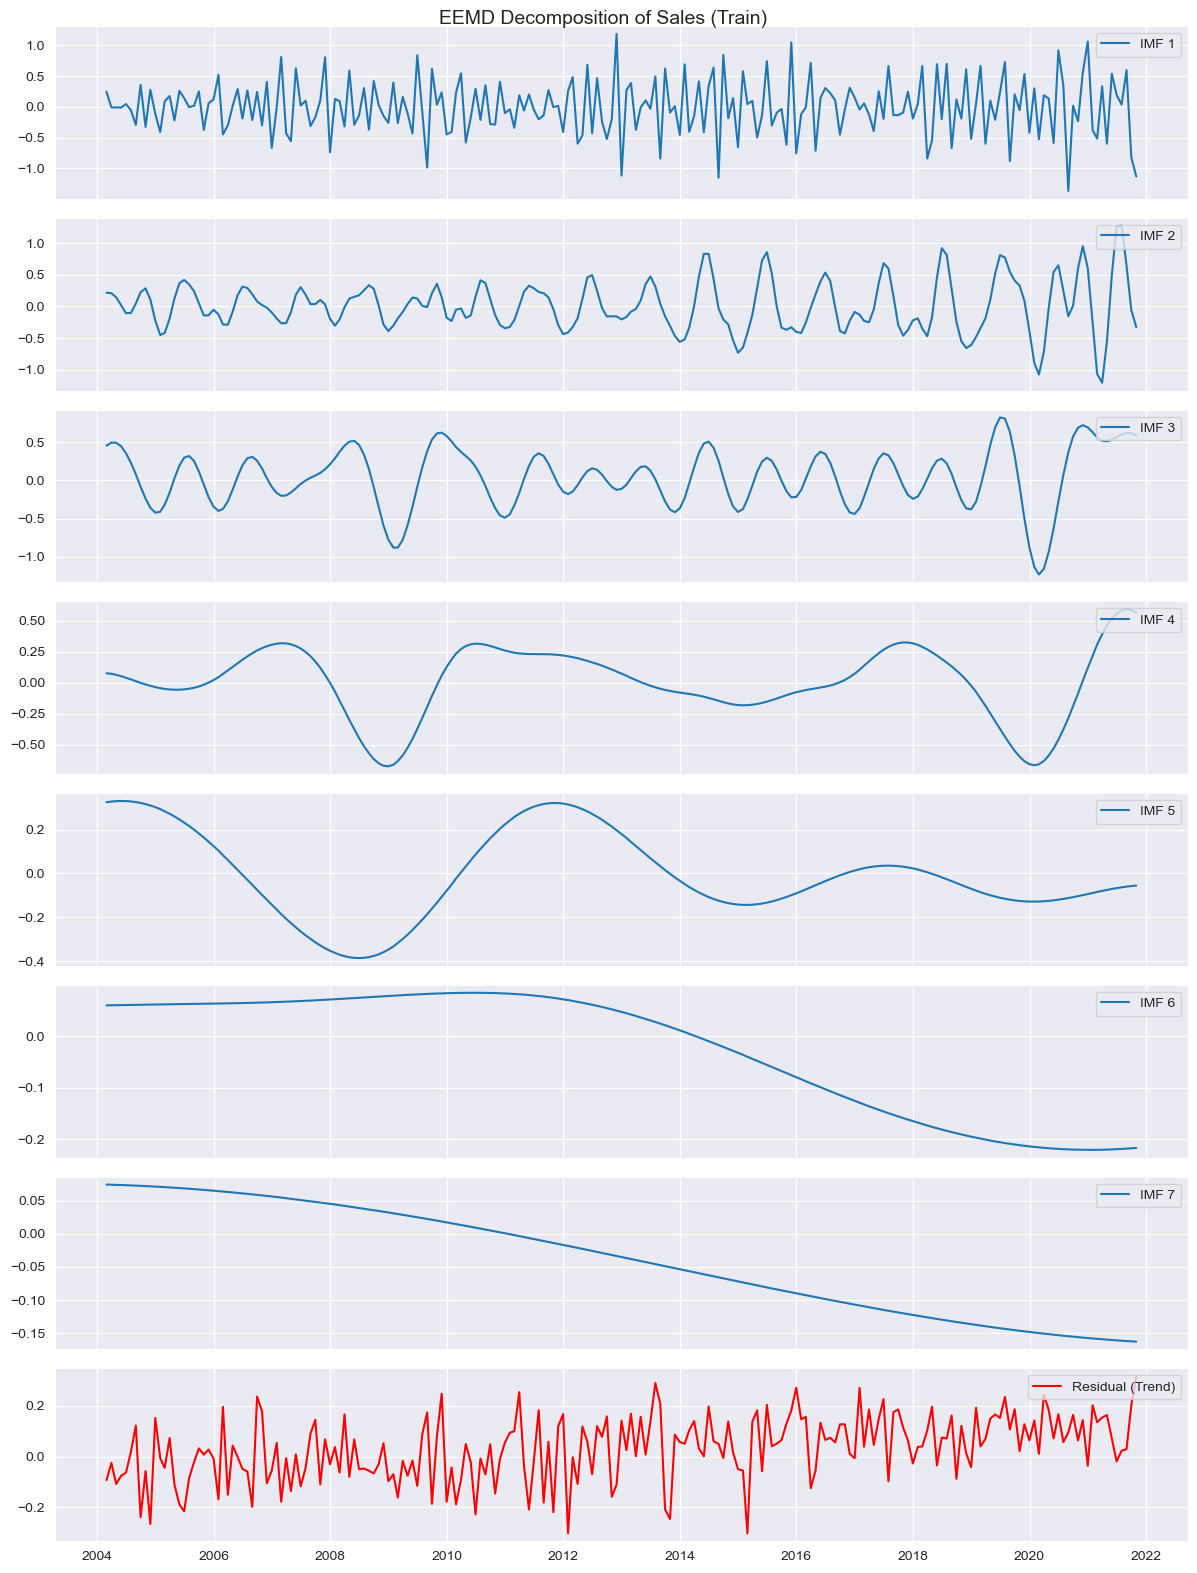

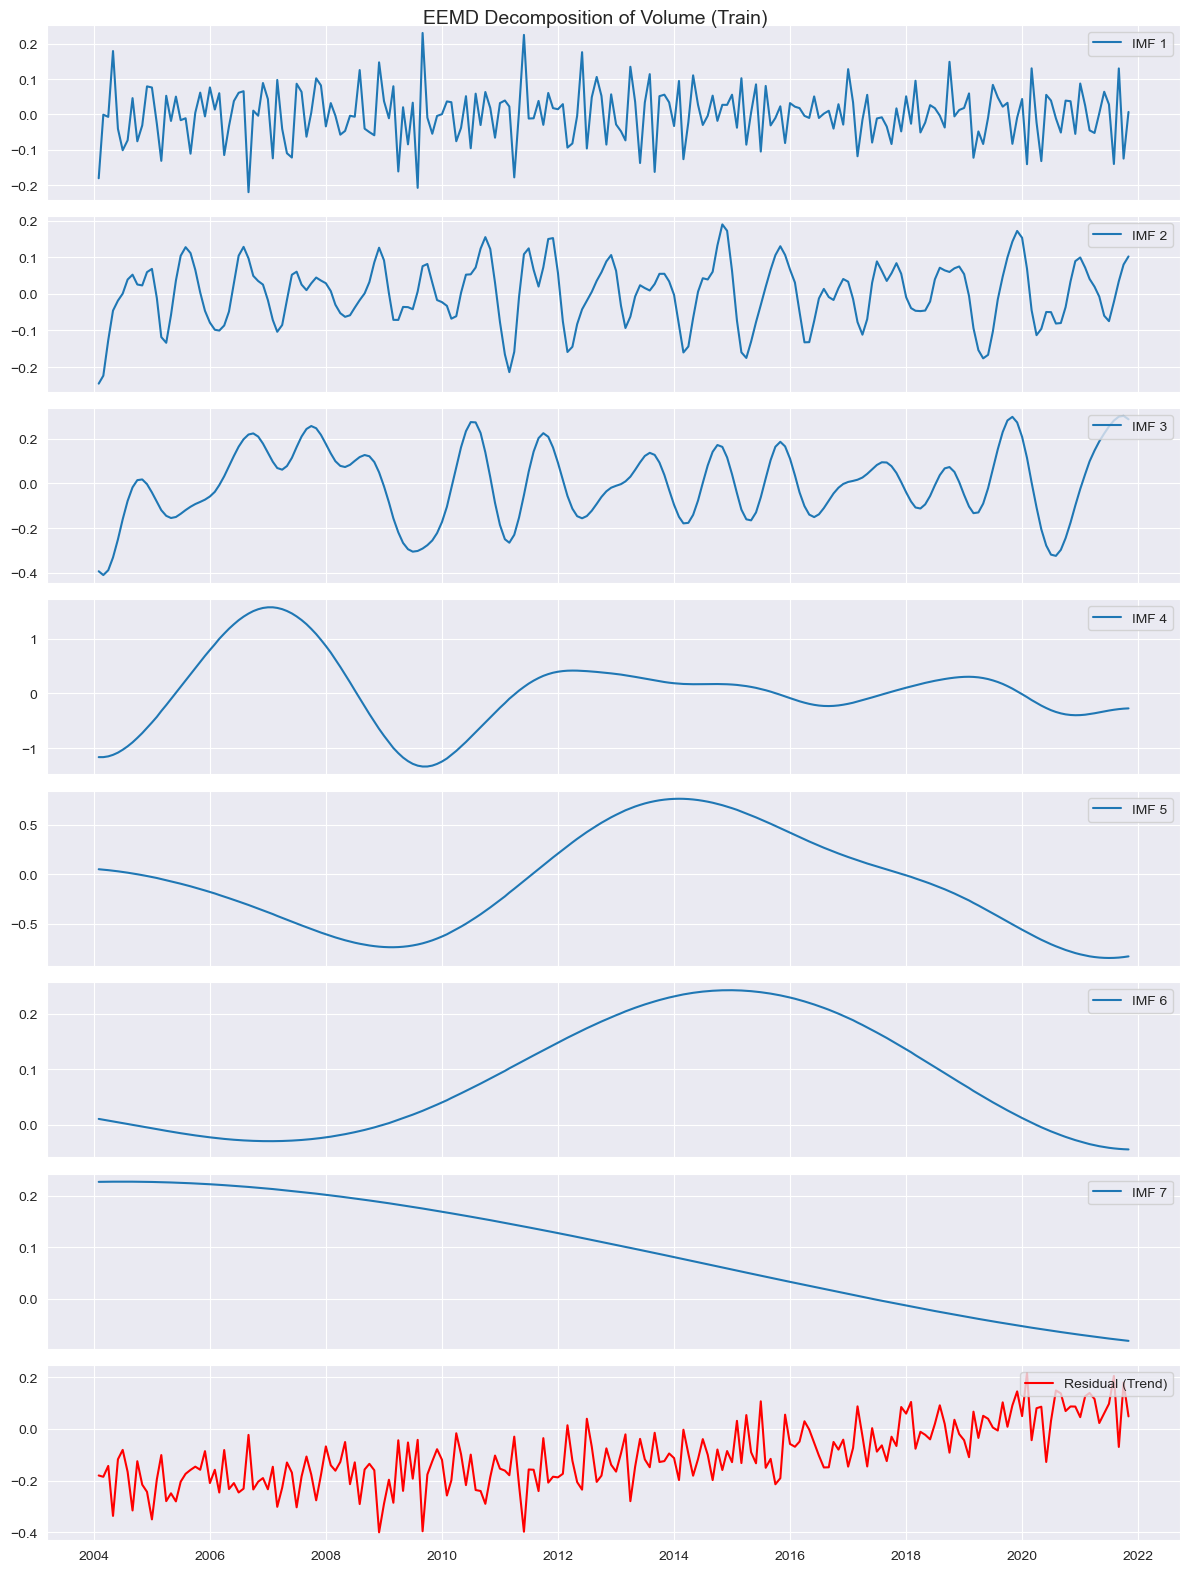

In [7]:
# === EEMD to create Intrinsic Mode Functions (IMFs) ===

def run_eemd(series, series_name="Series", noise_width=0.2, n_ensembles=100, max_imf=8):
    """
    Run EEMD on a given series (train set only).
    
    Parameters
    ----------
    series : pd.Series
        The time series to decompose.
    series_name : str
        Name of the series (for saving/plotting).
    noise_width : float
        Noise width for EEMD (default = 0.2).
    n_ensembles : int
        Number of ensembles (default = 100).
    max_imf : int
        Max number of IMFs to extract (default = 8).
    
    Returns
    -------
    imfs : np.ndarray
        Array of IMFs (shape: [n_imfs, len(series)]).
    residual : np.ndarray
        Residual component (trend).
    """
    eemd = EEMD()
    eemd.noise_width = noise_width
    eemd.trials = n_ensembles
    
    # Drop NaN explicitly before decomposition
    series = series.dropna()
    X = series.values.flatten()   # <-- ensure 1D
    t = np.arange(len(series))    # same length as X
    
    # Run EEMD
    imfs = eemd.eemd(X, t, max_imf)
    residual = X - np.sum(imfs, axis=0)
    
    # Plot decomposition
    n_imfs = imfs.shape[0]
    fig, axes = plt.subplots(n_imfs+1, 1, figsize=(12, 2*(n_imfs+1)), sharex=True)
    
    for i in range(n_imfs):
        axes[i].plot(series.index, imfs[i], label=f'IMF {i+1}')
        axes[i].legend(loc='upper right')
    axes[-1].plot(series.index, residual, label="Residual (Trend)", color="red")
    axes[-1].legend(loc='upper right')
    
    plt.suptitle(f"EEMD Decomposition of {series_name}", fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return imfs, residual


# === Apply to y1_train (Sales) and y2_train (Volume) ===
sales_imfs, sales_residual = run_eemd(y1_train, series_name="Sales (Train)", noise_width=0.2, n_ensembles=100, max_imf=8)
volume_imfs, volume_residual = run_eemd(y2_train, series_name="Volume (Train)", noise_width=0.2, n_ensembles=100, max_imf=8)

# Store in dicts for later use
eemd_results = {
    "sales": {"imfs": sales_imfs, "residual": sales_residual},
    "volume": {"imfs": volume_imfs, "residual": volume_residual}
}

## 4. Lag Selection and ARX Preparation

In [8]:
# === Robust ARX Feature Generator ===
def create_features(y_train, y_test, X_train, X_test, lags, series_name):
    """
    Create lagged target features (ARX setup) for train and test, properly aligned.
    
    Parameters
    ----------
    y_train : pd.Series
        Target training series.
    y_test : pd.Series
        Target test series.
    X_train : pd.DataFrame
        Exogenous predictors for training.
    X_test : pd.DataFrame
        Exogenous predictors for test.
    lags : int
        Number of lagged values of target to include.
    series_name : str
        Name of the target series (e.g., "Sales" or "Volume").
    
    Returns
    -------
    X_train : pd.DataFrame
        Training features including lagged target + exogenous.
    X_test : pd.DataFrame
        Test features including lagged target + exogenous.
    y_train : pd.Series
        Training target aligned to lagged features.
    y_test : pd.Series
        Test target aligned to lagged features.
    """
    # --- Lagged train ---
    lagged_train = pd.DataFrame(index=y_train.index)
    for lag in range(1, lags + 1):
        lagged_train[f"{series_name}_lag{lag}"] = y_train.shift(lag)
    X_train = pd.concat([lagged_train, X_train], axis=1).dropna()
    y_train = y_train.loc[X_train.index]

    # --- Lagged test ---
    combined = pd.concat([y_train.tail(lags), y_test])
    lagged_test = pd.DataFrame(index=combined.index)
    for lag in range(1, lags + 1):
        lagged_test[f"{series_name}_lag{lag}"] = combined.shift(lag)

    lagged_test = lagged_test.iloc[lags:]  # drop training tail
    # Reset indices for proper alignment
    X_test = pd.concat([lagged_test.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)
    y_test = y_test.reset_index(drop=True).iloc[:len(X_test)]  # match rows
    return X_train, X_test, y_train, y_test

# --- Sales (lag 1) ---
X1_train, X1_test, y1_train, y1_test = create_features(
    y1_train, y1_test, X1_train, X1_test, lags=1, series_name="Sales"
)

# --- Volume (lag 2) ---
X2_train, X2_test, y2_train, y2_test = create_features(
    y2_train, y2_test, X2_train, X2_test, lags=2, series_name="Volume"
)

print("Sales ARX Features:", X1_train.columns.tolist())
print("Volume ARX Features:", X2_train.columns.tolist())

Sales ARX Features: ['Sales_lag1', 'honda_queries_top']
Volume ARX Features: ['Volume_lag1', 'Volume_lag2', 'autotrader_queries_top', 'cars_for_sale_queries_top', 'suzuki_queries_top', 'ford_queries_top', 'ford_topics_top', 'gwm_queries_rising', 'kia_queries_top', 'honda_queries_top', 'cars_queries_top', 'volkswagen_topics_top']


## 4. Modelling

The plan is to investigate the effect of search data on the sales and volume using 5 different models. These models are given below:

<table style="width:100%">
  <thead>
    <tr>
      <th>Model</th>
      <th>Description</th>
      <th>Model Category</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>SARIMA</td>
      <td>Seasonal ARIMA without exogenous features. Captures linear seasonality and trend but limited in handling nonlinear patterns.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>SARIMAX</td>
      <td>SARIMA + Google Trends as exogenous regressors. Incorporates external signals (e.g., search behavior) to improve predictive accuracy.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSSVR</td>
      <td>Least Squares SVM regression. Strong at capturing nonlinear relationships, though it requires careful hyperparameter tuning.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LSTM</td>
      <td>Sequential neural model for time series. Learns long-term dependencies and nonlinearities but can be computationally heavy.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>BiLSTM</td>
      <td>Captures both forward and backward dependencies in sequences, offering richer temporal context than unidirectional LSTM.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>CNN-LSTM</td>
      <td>Combines CNN (local feature extraction) with LSTM (temporal learning). Effective for complex time series with both short- and long-term dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>GRU</td>
      <td>A simplified version of LSTM with fewer parameters. Trains faster while retaining the ability to model temporal dependencies.</td>
      <td>Deep Learning</td>
    </tr>
    <tr>
      <td>Prophet</td>
      <td>Additive time series model developed by Facebook. Designed for business forecasting, handles seasonality, holidays, and missing data robustly.</td>
      <td>Traditional</td>
    </tr>
    <tr>
      <td>LightGBM</td>
      <td>Gradient boosting framework optimized for speed and efficiency. Handles high-dimensional data well, supports feature importance analysis, and is strong at capturing nonlinear interactions.</td>
      <td>Machine Learning</td>
    </tr>
  </tbody>
</table>


### a. Helper Functions

In [41]:
# === Evaluation ===
def evaluate_model(y_true, y_pred, model_name="Model", fitted_model=None, conf_int=None, k=None):
    """
    Compute metrics for regression models, including AIC/BIC.
    Returns both metrics dict and DataFrame with predictions.
    """
    if hasattr(y_true, "index"):  
        index = y_true.index
        y_true = y_true.values.flatten()
    else:
        index = pd.RangeIndex(start=0, stop=len(y_true))
        y_true = np.array(y_true).flatten()

    y_pred = np.array(y_pred).flatten()
    residuals = y_true - y_pred
    rss, n = np.sum(residuals**2), len(y_true)

    # --- Metrics ---
    rmse = np.sqrt(rss / n)
    mae = np.mean(np.abs(residuals))
    mape = np.mean(np.abs(residuals / (y_true + 1e-10)))
    r2 = 1 - rss / np.sum((y_true - np.mean(y_true))**2)

    # --- AIC/BIC ---
    aic, bic = np.nan, np.nan
    if fitted_model is not None and hasattr(fitted_model, "aic") and hasattr(fitted_model, "bic"):
        aic, bic = fitted_model.aic, fitted_model.bic
    else:
        if k is None:
            k = 1
        aic = n * np.log(rss / n) + 2 * k
        bic = n * np.log(rss / n) + k * np.log(n)

    # --- Confidence intervals (if any) ---
    if conf_int is not None:
        ci_lower, ci_upper = conf_int[:, 0], conf_int[:, 1]
    else:
        ci_lower, ci_upper = np.full_like(y_pred, np.nan), np.full_like(y_pred, np.nan)

    df = pd.DataFrame({
        "y_true": y_true,
        "y_pred": y_pred,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    }, index=index)

    metrics = {"Model": model_name, "RMSE": rmse, "MAE": mae, "MAPE": mape,
               "R2": r2, "AIC": aic, "BIC": bic}
    return metrics, df


# === Classical & ML Models ===
def train_sarimax(y_train, X_train=None, order=(1,1,1), seasonal_order=(0,0,0,12)):
    """SARIMAX (or ARIMA if X_train=None)."""
    model = SARIMAX(y_train, exog=X_train, order=order, seasonal_order=seasonal_order)
    return model.fit(disp=False)

def train_lightgbm(X_train, y_train, params=None):
    """LightGBM regressor."""
    if params is None:
        params = {
    'objective': 'regression',
    'min_data_in_leaf': 1,
    'min_gain_to_split': 0,
    'num_leaves': 31,
    'learning_rate': 0.1,
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    return model

def train_lssvr(X_train, y_train, C=1.0, gamma="scale"):
    """Approximate LSSVR with sklearn SVR."""
    model = SVR(C=C, gamma=gamma)
    model.fit(X_train, y_train)
    return model


# === Prophet ===
def train_prophet(y_train, X_train=None):
    """Prophet with or without exogenous regressors."""
    df = y_train.reset_index()
    df.columns = ["ds", "y"]
    model = Prophet()
    if X_train is not None:
        for col in X_train.columns:
            model.add_regressor(col)
        df = pd.concat([df, X_train.reset_index(drop=True)], axis=1)
    model.fit(df)
    return model


# === Deep Learning Builders ===
def build_lstm(input_shape, units=64):
    model = Sequential([
        LSTM(units, activation="tanh", input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse")
    return model

def build_bilstm(input_shape, units=64):
    model = Sequential([
        Bidirectional(LSTM(units, activation="tanh"), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse")
    return model

def build_gru(input_shape, units=64):
    model = Sequential([
        GRU(units, activation="tanh", input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse")
    return model

def build_cnn_lstm(input_shape):
    timesteps = input_shape[0]
    kernel = 2 if timesteps >= 2 else 1
    model = Sequential([
        Conv1D(filters=64, kernel_size=kernel, activation="relu", input_shape=input_shape),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


# === DL Training ===
def train_deep_model(model_fn, X_train, y_train, X_test, y_test, epochs=50, batch_size=16):
    """Train DL model on lagged target (+ exo/EEMD if provided)."""
    if hasattr(X_train, "values"):  
        X_train_values, X_test_values = X_train.values, X_test.values
        feature_names = list(X_train.columns)
    else:
        X_train_values, X_test_values = X_train, X_test
        feature_names = [f"f{i}" for i in range(X_train.shape[1])]

    n_samples, n_features = X_train_values.shape
    timesteps = max(1, sum("lag" in f for f in feature_names))

    X_train_3d = X_train_values.reshape((n_samples, timesteps, n_features // timesteps))
    X_test_3d  = X_test_values.reshape((X_test_values.shape[0], timesteps, n_features // timesteps))

    model = model_fn(input_shape=(X_train_3d.shape[1], X_train_3d.shape[2]))
    model.fit(X_train_3d, y_train, validation_data=(X_test_3d, y_test),
              epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred = model.predict(X_test_3d).flatten()
    return model, y_pred

# ------------------------------------------------------
# Helper: run models for a given (X_train, X_test, label)
# ------------------------------------------------------
def run_all_models(y_train, y_test, X_train=None, X_test=None, label=""):
    local_results, local_pred_dfs = [], {}

    # --- SARIMAX ---
    sarimax_model = train_sarimax(y_train, X_train, order=(1,1,1), seasonal_order=(0,0,0,12))
    sarimax_forecast = sarimax_model.get_forecast(steps=len(y_test), exog=X_test)
    sarimax_pred = sarimax_forecast.predicted_mean
    sarimax_ci = sarimax_forecast.conf_int()

    metrics, df = evaluate_model(y_test, sarimax_pred,
                                 f"SARIMAX-Sales-{label}",
                                 fitted_model=sarimax_model,
                                 conf_int=sarimax_ci.values,
                                 k=None if X_train is None else X_train.shape[1])
    local_results.append(metrics)
    local_pred_dfs[f"SARIMAX-Sales-{label}"] = df

    # --- LightGBM (skip if no features) ---
    if X_train is not None:
        lgbm_model = train_lightgbm(X_train, y_train)
        lgbm_pred = lgbm_model.predict(X_test)

        metrics, df = evaluate_model(y_test, lgbm_pred,
                                     f"LightGBM-Sales-{label}",
                                     k=X_train.shape[1])
        local_results.append(metrics)
        local_pred_dfs[f"LightGBM-Sales-{label}"] = df

        # --- LSSVR ---
        lssvr_model = train_lssvr(X_train, y_train)
        lssvr_pred = lssvr_model.predict(X_test)

        metrics, df = evaluate_model(y_test, lssvr_pred,
                                     f"LSSVR-Sales-{label}",
                                     k=X_train.shape[1])
        local_results.append(metrics)
        local_pred_dfs[f"LSSVR-Sales-{label}"] = df

    # --- Prophet ---
    prophet_model = train_prophet(y_train, X_train)

    future = pd.DataFrame({"ds": pd.to_datetime(y_test.index)})
    if X_test is not None:
        for col in X_test.columns:
            future[col] = X_test[col].values

    prophet_forecast = prophet_model.predict(future)
    prophet_pred = prophet_forecast["yhat"].values
    prophet_ci = prophet_forecast[["yhat_lower", "yhat_upper"]].values

    metrics, df = evaluate_model(y_test, prophet_pred,
                                 f"Prophet-Sales-{label}",
                                 conf_int=prophet_ci,
                                 k=None if X_train is None else X_train.shape[1])
    local_results.append(metrics)
    local_pred_dfs[f"Prophet-Sales-{label}"] = df

    # --- Deep Learning ---
    if X_train is not None:
        dl_models = {
            "LSTM": build_lstm,
            "BiLSTM": build_bilstm,
            "GRU": build_gru,
            "CNN-LSTM": build_cnn_lstm,
        }
        for name, builder in dl_models.items():
            dl_model, dl_pred = train_deep_model(builder,
                                                 X_train, y_train,
                                                 X_test, y_test,
                                                 epochs=50, batch_size=16)
            metrics, df = evaluate_model(y_test, dl_pred,
                                         f"{name}-Sales-{label}",
                                         k=X_train.shape[1])
            local_results.append(metrics)
            local_pred_dfs[f"{name}-Sales-{label}"] = df

    return local_results, local_pred_dfs

### b. Sales

#### i. Model Training

In [42]:
# === Sales Experiments (Baseline, Exogenous, EEMD) ===
results = []
pred_dfs = {}

# ------------------------------------------------------
# 1. Baseline (lags only)
# ------------------------------------------------------
baseline_results, baseline_dfs = run_all_models(y1_train, y1_test,
                                                X_train=X1_train,
                                                X_test=X1_test,
                                                label="Baseline")
results.extend(baseline_results)
pred_dfs.update(baseline_dfs)

# ------------------------------------------------------
# 2. Exogenous (lags + extra regressors)
# ------------------------------------------------------
exo_results, exo_dfs = run_all_models(y1_train, y1_test,
                                      X_train=X1_train,
                                      X_test=X1_test,
                                      label="Exogenous")
results.extend(exo_results)
pred_dfs.update(exo_dfs)

# ------------------------------------------------------
# 3. EEMD-enhanced (lags + regressors + IMFs/residual)
# ------------------------------------------------------
sales_imfs, sales_resid = eemd_results["sales"]["imfs"], eemd_results["sales"]["residual"]

# Align IMFs to lagged training series
imf_cols = [f"IMF{i+1}" for i in range(sales_imfs.shape[0])]
eemd_train = pd.DataFrame(
    sales_imfs[:, -len(y1_train):].T,
    index=y1_train.index,
    columns=imf_cols
)
eemd_train["Residual"] = sales_resid[-len(y1_train):]

# Test features (repeat last known value)
eemd_test = pd.DataFrame(index=y1_test.index, columns=eemd_train.columns)
for col in eemd_train.columns:
    eemd_test[col] = eemd_train[col].iloc[-1]

# Combine with original X features
X1_train_eemd = pd.concat([X1_train, eemd_train], axis=1).fillna(0)
X1_test_eemd  = pd.concat([X1_test, eemd_test], axis=1).fillna(0)

# Optional: remove constant columns
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=1e-5)
selector.fit(X1_train_eemd)
X1_train_eemd = X1_train_eemd[X1_train_eemd.columns[selector.get_support()]]
X1_test_eemd  = X1_test_eemd[X1_test_eemd.columns[selector.get_support()]]

# Run models
eemd_results_, eemd_dfs = run_all_models(y1_train, y1_test,
                                         X_train=X1_train_eemd,
                                         X_test=X1_test_eemd,
                                         label="EEMD")
results.extend(eemd_results_)
pred_dfs.update(eemd_dfs)

# ------------------------------------------------------
# Final results
# ------------------------------------------------------
results_df = pd.DataFrame(results)
results_df


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 2
[LightGBM] [Info] Start training from score -0.006394
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gai

04:38:55 - cmdstanpy - INFO - Chain [1] start processing
04:38:55 - cmdstanpy - INFO - Chain [1] done processing


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 2
[LightGBM] [Info] Start training from score -0.006394
[LightGBM] [Warning] min_d

04:39:21 - cmdstanpy - INFO - Chain [1] start processing
04:39:21 - cmdstanpy - INFO - Chain [1] done processing


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 212, number of used features: 10
[LightGBM] [Info] Start training from score -0.006394
[LightGBM] [Warning] min

04:39:46 - cmdstanpy - INFO - Chain [1] start processing
04:39:47 - cmdstanpy - INFO - Chain [1] done processing


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


,Model,RMSE,MAE,MAPE,R2,AIC,BIC
0,SARIMAX-Sales-Baseline,178.366306,178.048883,1.155710,-555.278844,506.209182,522.968472
1,LightGBM-Sales-Baseline,152.642006,152.459805,0.990084,-406.394385,426.360010,429.835349
2,LSSVR-Sales-Baseline,154.661143,154.475364,1.003162,-417.243633,427.463870,430.939210
3,Prophet-Sales-Baseline,63.023402,61.966885,0.404478,-68.449735,352.054514,355.529853
4,LSTM-Sales-Baseline,154.174174,153.988432,0.999996,-414.613996,427.198969,430.674308
5,BiLSTM-Sales-Baseline,154.794327,154.607401,1.004012,-417.964272,427.536175,431.011514
6,GRU-Sales-Baseline,154.846370,154.659136,1.004346,-418.246033,427.564411,431.039750
7,CNN-LSTM-Sales-Baseline,152.278417,152.096813,0.987729,-404.455888,426.159685,429.635024
8,SARIMAX-Sales-Exogenous,178.366306,178.048883,1.155710,-555.278844,506.209182,522.968472
9,LightGBM-Sales-Exogenous,152.642006,152.459805,0.990084,-406.394385,426.360010,429.835349


In [ ]:
# ---------------------------
# ---- FORECAST DATAFRAMES ----
# ---------------------------

# Univariate forecasts
sales_forecast_dfs_uni = {}
for model_name, forecast_tuple in forecasts_uni.items():
    df = create_forecast_df(forecast_tuple, y1_test_scaled.index)
    sales_forecast_dfs_uni[model_name + "_Sales_forecast_results"] = df

# Multivariate forecasts
sales_forecast_dfs_multi = {}
for model_name, forecast_tuple in forecasts_multi.items():
    df = create_forecast_df(forecast_tuple, y1_test_scaled.index)
    sales_forecast_dfs_multi[model_name + "_Sales_forecast_results"] = df

# ---------------------------
# ---- METRICS DATAFRAMES ----
# ---------------------------

# Univariate metrics
salesUnivarResults = pd.DataFrame(results_uni)
salesUnivarResults.columns = ["model", "aic", "bic", "rmse", "mape", "mae", "r2"]

# Multivariate metrics
salesMultivarResults = pd.DataFrame(results_multi)
salesMultivarResults.columns = ["model", "aic", "bic", "rmse", "mape", "mae", "r2"]

# ---------------------------
# ---- SAVE RESULTS TO EXCEL WITH FOLDER STRUCTURE ----
# ---------------------------

base_dir = "forecast_results"

# Define folder structure
folders = {
    "UnivarForecasts": ["Sales", "Volume"],
    "MultiForecasts": ["Sales", "Volume"]
}

# Create all folders
for main_folder, subfolders in folders.items():
    for sub in subfolders:
        path = os.path.join(base_dir, main_folder, sub)
        os.makedirs(path, exist_ok=True)

# Save univariate forecasts as Excel
for name, df in sales_forecast_dfs_uni.items():
    file_path = os.path.join(base_dir, "UnivarForecasts", "Sales", f"{name}.xlsx")
    df.to_excel(file_path, index=True)

# Save multivariate forecasts as Excel
for name, df in sales_forecast_dfs_multi.items():
    file_path = os.path.join(base_dir, "MultiForecasts", "Sales", f"{name}.xlsx")
    df.to_excel(file_path, index=True)

# Save metrics as Excel
salesUnivarResults.to_excel(os.path.join(base_dir,"salesUnivarResults.xlsx"), index=False)
salesMultivarResults.to_excel(os.path.join(base_dir,"salesMultivarResults.xlsx"), index=False)

print(f"All forecast and metrics Excel files saved under: {os.path.abspath(base_dir)}")


All forecast and metrics Excel files saved under: c:\Users\202215639\OneDrive - Sol Plaatje University\Sol Plaatje\Honors\Research\Code\forecast_results


#### ii. Results

In [24]:
print("\n=== Univariate Sales Prediction Results ===")
salesUnivarResults


=== Univariate Sales Prediction Results ===


,model,aic,bic,rmse,mape,mae,r2
0,SARIMA,-149.67,-144.60,0.05,0.05,10.54,-0.94
1,LSSVR-Uni,-146.14,-144.45,0.05,0.04,6.89,-0.71
2,LSTM-Uni,-30.34,74.37,0.05,0.04,3.41,-0.60
3,BiLSTM-Uni,107.43,212.14,0.29,0.22,145.33,-58.50
4,CNN-LSTM-Uni,99.99,312.79,0.04,0.03,2.33,0.04
5,GRU-Uni,-18.85,85.86,0.07,0.06,14.38,-2.03
6,PROPHET-Uni,-141.68,-136.61,0.05,0.04,4.08,-0.41
7,LIGHTGBM-Uni,-115.92,-95.65,0.06,0.05,7.12,-1.76
8,SARIMA-Uni_EEMD,-116.01,-110.95,0.11,0.09,59.46,-6.85
9,LSSVR-Uni_EEMD,-124.14,-103.88,0.04,0.04,2.72,-0.31


In [25]:
print("\n=== Multivariate Sales Prediction Results ===")
salesMultivarResults


=== Multivariate Sales Prediction Results ===


,model,aic,bic,rmse,mape,mae,r2
0,SARIMAX-Multi,-135.30,-121.79,0.06,0.05,11.99,-1.21
1,LSSVR-Multi,-138.14,-129.70,0.05,0.04,6.89,-0.71
2,LSTM-Multi,-35.38,-26.94,0.24,0.21,103.23,-37.78
3,BiLSTM-Multi,-24.20,-15.75,0.27,0.24,126.07,-50.29
4,CNN-LSTM-Multi,-73.27,-64.82,0.17,0.15,65.42,-17.94
5,GRU-Multi,-94.71,-86.26,0.12,0.10,38.59,-8.37
6,LIGHTGBM-Multi,-143.36,-134.92,0.06,0.05,9.09,-1.20
7,PROPHET-Multi,-141.68,-136.61,0.05,0.04,4.08,-0.41
8,SARIMAX-Multi_EEMD,-145.57,-132.06,0.03,0.03,18.95,0.17
9,LSSVR-Multi_EEMD,-138.14,-129.70,0.05,0.04,4.16,-0.43


In [27]:
print("\n=== Example of Forecast Datasets ===")
sales_forecast_dfs_uni["LSTM-Uni_Sales_forecast_results"].info()


=== Example of Forecast Datasets ===
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40 entries, 2022-01-31 to 2025-04-30
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  40 non-null     float64
 1   lower_CI    40 non-null     float64
 2   upper_CI    40 non-null     float64
dtypes: float64(3)
memory usage: 1.2 KB


### c. Volume

#### i. Model Training

In [ ]:
# FULL MODEL TRAINING PIPELINE (Volume)
# ---------------------------

# ---------------------------
# Ensure NumPy arrays
# ---------------------------
y2_train_np = y2_train.values.flatten() if hasattr(y2_train, "values") else y2_train.flatten()
y2_test_np  = y2_test.values.flatten()  if hasattr(y2_test, "values") else y2_test.flatten()
X2_train_np = X2_train.values if hasattr(X2_train, "values") else X2_train
X2_test_np  = X2_test.values  if hasattr(X2_test, "values") else X2_test

lags = 2
epochs = 30
batch_size = 8
ensemble_size = 50
noise_strength = 0.2
alpha = 0.05

# ---------------------------
# Containers
# ---------------------------
results_uni = []
forecasts_uni = {}
results_multi = []
forecasts_multi = {}

# ---------------------------
# ---- UNIVARIATE MODELS ----
# ---------------------------

# SARIMA
_, sarima_forecast, sarima_ci = train_sarima(y2_train_np, steps=len(y2_test_np))
results_uni.append(evaluate_model("SARIMA", y2_test_np, sarima_forecast, k=3))
forecasts_uni["SARIMA"] = (sarima_forecast, sarima_ci)

# LSSVR-Uni
_, lssvr_forecast = call_train_svr(X2_train_np[:, :1], y2_train_np, X2_test_np[:, :1])
lssvr_lower, lssvr_upper = compute_residual_ci(y2_train_np, lssvr_forecast)
results_uni.append(evaluate_model("LSSVR-Uni", y2_test_np, lssvr_forecast, k=1))
forecasts_uni["LSSVR-Uni"] = (lssvr_forecast, (lssvr_lower, lssvr_upper))

# LSTM-Uni
_, lstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="lstm",
                                       lags=lags, epochs=epochs, batch_size=batch_size)
lstm_lower, lstm_upper = compute_residual_ci(y2_train_np, lstm_forecast)
results_uni.append(evaluate_model("LSTM-Uni", y2_test_np, lstm_forecast, k=lags+50))
forecasts_uni["LSTM-Uni"] = (lstm_forecast, (lstm_lower, lstm_upper))

# BiLSTM-Uni
_, bilstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="bilstm",
                                         lags=lags, epochs=epochs, batch_size=batch_size)
bilstm_lower, bilstm_upper = compute_residual_ci(y2_train_np, bilstm_forecast)
results_uni.append(evaluate_model("BiLSTM-Uni", y2_test_np, bilstm_forecast, k=lags+50))
forecasts_uni["BiLSTM-Uni"] = (bilstm_forecast, (bilstm_lower, bilstm_upper))

# CNN-LSTM-Uni
_, cnnlstm_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="cnnlstm",
                                          lags=lags, epochs=epochs, batch_size=batch_size)
cnnlstm_lower, cnnlstm_upper = compute_residual_ci(y2_train_np, cnnlstm_forecast)
results_uni.append(evaluate_model("CNN-LSTM-Uni", y2_test_np, cnnlstm_forecast, k=lags+50+64))
forecasts_uni["CNN-LSTM-Uni"] = (cnnlstm_forecast, (cnnlstm_lower, cnnlstm_upper))

# GRU-Uni
_, gru_forecast = train_nn_univariate(y2_train_np, y2_test_np, model_type="gru",
                                      lags=lags, epochs=epochs, batch_size=batch_size)
gru_lower, gru_upper = compute_residual_ci(y2_train_np, gru_forecast)
results_uni.append(evaluate_model("GRU-Uni", y2_test_np, gru_forecast, k=lags+50))
forecasts_uni["GRU-Uni"] = (gru_forecast, (gru_lower, gru_upper))

# Prophet-Uni
_, prophet_forecast = prophet_univariate_wrapper(y2_train_np, y2_test_np)
results_uni.append(evaluate_model("PROPHET-Uni", y2_test_np, prophet_forecast, k=3))
forecasts_uni["PROPHET-Uni"] = (prophet_forecast, (None, None))

# LightGBM-Uni
_, lgb_forecast = lgb_univariate_wrapper(y2_train_np, y2_test_np, lags=lags)
lgb_lower, lgb_upper = compute_residual_ci(y2_train_np, lgb_forecast)
results_uni.append(evaluate_model("LIGHTGBM-Uni", y2_test_np, lgb_forecast, k=lags))
forecasts_uni["LIGHTGBM-Uni"] = (lgb_forecast, (lgb_lower, lgb_upper))

# ---------------------------
# ---- MULTIVARIATE MODELS ----
# ---------------------------
X2_train_nn_lagged, y2_train_nn_lagged = create_multivariate_lags(X2_train_np, y2_train_np, lags=lags)

# SARIMAX
_, sarimax_forecast, sarimax_ci = train_sarimax(y2_train_np, X2_train_np, X2_test_np, steps=len(y2_test_np))
results_multi.append(evaluate_model("SARIMAX-Multi", y2_test_np, sarimax_forecast, k=3+X2_train_np.shape[1]))
forecasts_multi["SARIMAX-Multi"] = (sarimax_forecast, sarimax_ci)

# LSSVR-Multi
_, lssvr_mv_forecast = call_train_svr_multi(X2_train_np, y2_train_np, X2_test_np)
lssvr_mv_lower, lssvr_mv_upper = compute_residual_ci(y2_train_np, lssvr_mv_forecast)
results_multi.append(evaluate_model("LSSVR-Multi", y2_test_np, lssvr_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["LSSVR-Multi"] = (lssvr_mv_forecast, (lssvr_mv_lower, lssvr_mv_upper))

# LSTM-Multi
_, lstm_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged,
                                                   X2_train_np, X2_test_np,
                                                   model_type="lstm", lags=lags,
                                                   epochs=epochs, batch_size=batch_size)
lstm_mv_lower, lstm_mv_upper = compute_residual_ci(y2_train_np, lstm_mv_forecast)
results_multi.append(evaluate_model("LSTM-Multi", y2_test_np, lstm_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["LSTM-Multi"] = (lstm_mv_forecast, (lstm_mv_lower, lstm_mv_upper))

# BiLSTM-Multi
_, bilstm_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged,
                                                     X2_train_np, X2_test_np,
                                                     model_type="bilstm", lags=lags,
                                                     epochs=epochs, batch_size=batch_size)
bilstm_mv_lower, bilstm_mv_upper = compute_residual_ci(y2_train_np, bilstm_mv_forecast)
results_multi.append(evaluate_model("BiLSTM-Multi", y2_test_np, bilstm_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["BiLSTM-Multi"] = (bilstm_mv_forecast, (bilstm_mv_lower, bilstm_mv_upper))

# CNN-LSTM-Multi
_, cnnlstm_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged,
                                                      X2_train_np, X2_test_np,
                                                      model_type="cnnlstm", lags=lags,
                                                      epochs=epochs, batch_size=batch_size)
cnnlstm_mv_lower, cnnlstm_mv_upper = compute_residual_ci(y2_train_np, cnnlstm_mv_forecast)
results_multi.append(evaluate_model("CNN-LSTM-Multi", y2_test_np, cnnlstm_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["CNN-LSTM-Multi"] = (cnnlstm_mv_forecast, (cnnlstm_mv_lower, cnnlstm_mv_upper))

# GRU-Multi
_, gru_mv_forecast = train_nn_multivariate_direct(X2_train_nn_lagged, y2_train_nn_lagged,
                                                  X2_train_np, X2_test_np,
                                                  model_type="gru", lags=lags,
                                                  epochs=epochs, batch_size=batch_size)
gru_mv_lower, gru_mv_upper = compute_residual_ci(y2_train_np, gru_mv_forecast)
results_multi.append(evaluate_model("GRU-Multi", y2_test_np, gru_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["GRU-Multi"] = (gru_mv_forecast, (gru_mv_lower, gru_mv_upper))

# LightGBM-Multi
_, lgb_mv_forecast = lgb_multivariate_wrapper(X2_train_np, y2_train_np, X2_test_np)
lgb_mv_lower, lgb_mv_upper = compute_residual_ci(y2_train_np, lgb_mv_forecast)
results_multi.append(evaluate_model("LIGHTGBM-Multi", y2_test_np, lgb_mv_forecast, k=X2_train_np.shape[1]))
forecasts_multi["LIGHTGBM-Multi"] = (lgb_mv_forecast, (lgb_mv_lower, lgb_mv_upper))

# Prophet-Multi
_, prophet_mv_forecast = prophet_multivariate_wrapper(X2_train_np, y2_train_np, X2_test_np)
results_multi.append(evaluate_model("PROPHET-Multi", y2_test_np, prophet_mv_forecast, k=3))
forecasts_multi["PROPHET-Multi"] = (prophet_mv_forecast, (None, None))

# ---------------------------
# ---- EEMD-ENHANCED MODELS ----
# ---------------------------

# Univariate EEMD
for wrapper, name, k, kwargs in [
    (sarima_wrapper_univariate, "SARIMA-Uni_EEMD", 3, {}),
    (svr_univariate_wrapper, "LSSVR-Uni_EEMD", lags, {"lags": lags}),
    (nn_univariate_wrapper, "LSTM-Uni_EEMD", lags+50, {"model_type": "lstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_univariate_wrapper, "BiLSTM-Uni_EEMD", lags+50, {"model_type": "bilstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_univariate_wrapper, "CNN-LSTM-Uni_EEMD", lags+50+64, {"model_type": "cnnlstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_univariate_wrapper, "GRU-Uni_EEMD", lags+50, {"model_type": "gru", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (prophet_univariate_wrapper, "PROPHET-Uni_EEMD", 3, {}),
    (lgb_univariate_wrapper, "LIGHTGBM-Uni_EEMD", lags, {"lags": lags})
]:
    metrics, (forecast, ci) = forecast_with_eemd_univariate(
        y2_train_np, y2_test_np, wrapper, k=k, name=name,
        ensemble_size=ensemble_size, noise_strength=noise_strength,
        return_forecast=True, **kwargs
    )
    results_uni.append(metrics)
    forecasts_uni[name] = (forecast, ci)

# Multivariate EEMD
for wrapper, name, k, kwargs in [
    (sarimax_multivariate_wrapper, "SARIMAX-Multi_EEMD", 3+X2_train_np.shape[1], {}),
    (svr_multivariate_wrapper, "LSSVR-Multi_EEMD", X2_train_np.shape[1], {}),
    (nn_multivariate_wrapper, "LSTM-Multi_EEMD", X2_train_np.shape[1], {"model_type": "lstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_multivariate_wrapper, "BiLSTM-Multi_EEMD", X2_train_np.shape[1], {"model_type": "bilstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_multivariate_wrapper, "CNN-LSTM-Multi_EEMD", X2_train_np.shape[1], {"model_type": "cnnlstm", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (nn_multivariate_wrapper, "GRU-Multi_EEMD", X2_train_np.shape[1], {"model_type": "gru", "lags": lags, "epochs": epochs, "batch_size": batch_size}),
    (lgb_multivariate_wrapper, "LIGHTGBM-Multi_EEMD", X2_train_np.shape[1], {}),
    (prophet_multivariate_wrapper, "PROPHET-Multi_EEMD", 3, {})
]:
    metrics, (forecast, ci) = forecast_with_eemd_multivariate(
        X2_train_np, X2_test_np, y2_train_np, y2_test_np,
        wrapper, k=k, name=name,
        ensemble_size=ensemble_size, noise_strength=noise_strength,
        return_forecast=True, **kwargs
    )
    results_multi.append(metrics)
    forecasts_multi[name] = (forecast, ci)

In [40]:
# ---------------------------
# ---- FORECAST DATAFRAMES ----
# ---------------------------

# Univariate Volume forecasts
volume_forecast_dfs_uni = {}
for model_name, forecast_tuple in forecasts_uni.items():
    df = create_forecast_df(forecast_tuple, y2_test_scaled.index)
    volume_forecast_dfs_uni[model_name + "_Volume_forecast_results"] = df

# Multivariate Volume forecasts
volume_forecast_dfs_multi = {}
for model_name, forecast_tuple in forecasts_multi.items():
    df = create_forecast_df(forecast_tuple, y2_test_scaled.index)
    volume_forecast_dfs_multi[model_name + "_Volume_forecast_results"] = df

# ---------------------------
# ---- METRICS DATAFRAMES ----
# ---------------------------

# Univariate metrics for Volume
volumeUnivarResults = pd.DataFrame(results_uni)
volumeUnivarResults.columns = ["model", "aic", "bic", "rmse", "mape", "mae", "r2"]

# Multivariate metrics for Volume
volumeMultivarResults = pd.DataFrame(results_multi)
volumeMultivarResults.columns = ["model", "aic", "bic", "rmse", "mape", "mae", "r2"]

# ---------------------------
# ---- SAVE RESULTS TO EXCEL WITH FOLDER STRUCTURE ----
# ---------------------------

base_dir = "forecast_results"

# Define folder structure
folders = {
    "UnivarForecasts": ["Sales", "Volume"],
    "MultiForecasts": ["Sales", "Volume"]
}

# Create all folders
for main_folder, subfolders in folders.items():
    for sub in subfolders:
        path = os.path.join(base_dir, main_folder, sub)
        os.makedirs(path, exist_ok=True)

# Save univariate Volume forecasts as Excel
for name, df in volume_forecast_dfs_uni.items():
    file_path = os.path.join(base_dir, "UnivarForecasts", "Volume", f"{name}.xlsx")
    df.to_excel(file_path, index=True)

# Save multivariate Volume forecasts as Excel
for name, df in volume_forecast_dfs_multi.items():
    file_path = os.path.join(base_dir, "MultiForecasts", "Volume", f"{name}.xlsx")
    df.to_excel(file_path, index=True)

# Save metrics as Excel
volumeUnivarResults.to_excel(os.path.join(base_dir,"volumeUnivarResults.xlsx"), index=False)
volumeMultivarResults.to_excel(os.path.join(base_dir,"volumeMultivarResults.xlsx"), index=False)

print(f"All Volume forecast and metrics Excel files saved under: {os.path.abspath(base_dir)}")


All Volume forecast and metrics Excel files saved under: c:\Users\202215639\OneDrive - Sol Plaatje University\Sol Plaatje\Honors\Research\Code\forecast_results


#### ii. Results

In [ ]:
print("\n=== Univariate Volume Prediction Results ===")
volumeUnivarResults


=== Univariate Sales Prediction Results ===


,model,aic,bic,rmse,mape,mae,r2
0,SARIMA,53.45,58.51,0.93,0.84,16.08,-9.42
1,LSSVR-Uni,29.84,31.53,0.48,0.37,3.07,-1.76
2,LSTM-Uni,151.84,256.55,0.74,0.67,13.66,-5.61
3,BiLSTM-Uni,196.93,301.64,1.65,1.53,30.53,-31.43
4,CNN-LSTM-Uni,308.98,521.78,0.96,0.83,8.57,-10.08
5,GRU-Uni,170.34,275.05,1.08,0.99,19.06,-12.90
6,PROPHET-Uni,24.73,29.79,0.31,0.24,3.54,-0.12
7,LIGHTGBM-Uni,69.11,89.38,1.04,0.95,18.64,-12.03
8,SARIMA-Uni_EEMD,67.50,72.56,1.38,1.28,22.94,-21.66
9,LSSVR-Uni_EEMD,43.92,64.18,0.61,0.53,12.55,-3.47


In [39]:
print("\n=== Multivariate Volume Prediction Results ===")
volumeMultivarResults


=== Multivariate Volume Prediction Results ===


,model,aic,bic,rmse,mape,mae,r2
0,SARIMAX-Multi,41.31,54.82,0.76,0.69,14.18,-5.97
1,LSSVR-Multi,56.16,64.61,0.48,0.42,7.44,-1.76
2,LSTM-Multi,75.36,83.81,0.73,0.58,15.53,-5.40
3,BiLSTM-Multi,102.52,110.97,0.86,0.75,19.50,-7.86
4,CNN-LSTM-Multi,88.21,96.65,1.12,0.98,21.83,-13.97
5,GRU-Multi,127.92,136.36,1.16,1.04,25.24,-15.12
6,LIGHTGBM-Multi,71.87,80.31,0.55,0.48,9.11,-2.65
7,PROPHET-Multi,24.73,29.79,0.31,0.24,3.54,-0.12
8,SARIMAX-Multi_EEMD,67.19,80.70,1.03,0.92,17.40,-11.62
9,LSSVR-Multi_EEMD,59.36,67.80,0.45,0.38,5.94,-1.45


In [ ]:
print("\n=== Example of Forecast Datasets ===")
volume_forecast_dfs_uni["LSTM-Uni_Volume_forecast_results"].info()